# Customer Churn Prediction with IBM Db2 Warehouse using sklearn

__Introduction__

This notebook presents a churn prediction use case using anonymized customer data from a phone operator. It uses IBM Db2 Warehouse and runs on a Python3 kernel. Some visualizations are plotted locally using seaborn and matplotlib, modelisation is done with sklearn. Data is accessed to using ibmdbPy. The ibmdbPy package provides methods to read data from, write data to, and sample data from a Db2 database. It also provides access methods for in-database analytic or geospatial functions. For more information abour ibmdbpy, please follow this [link](https://www.ibm.com/support/knowledgecenter/fr/SSFMBX/com.ibm.swg.im.dashdb.analytics.doc/doc/analyze_python.html).

Our goal is to accurately predict whether a customer is going to end his/her contract (labeled as positive,1). We prefer to send a commercial email to someone who intends to keep her contract but is labeled as willing to end it (false positive) rather than to overlook the opportunity to prevent a customer from ending her contract (false negative), but also care not to overwhelm our customers with commercials or to lose money by proposing special offers to too many people. Our optimization objective will here be to maximize recall. We will also look at other classic metrics too.

__Contents__
1. Get ready
2. Explore the data
3. Train your first models
4. Find the best hyperparameters with a grid search
5. Assess your model performance on the test set
6. Save your model for future use


__Requirements:__

* connection to Db2 Warehouse
* ibmdbpy for accessing data from Db2 Warehouse
* Python 3 including pandas, sklearn, joblib

## 1. Get ready

__Imports__

Lets start by loading ibmdbPy. We will also need to import JayDeBeAPI package to connect to the database using JDBC from ibmdbPy.

In [1]:
import jaydebeapi
from ibmdbpy import IdaDataBase
from ibmdbpy import IdaDataFrame

We import pandas for data exploration and transformation, sklearn for modelisation and evaluation, joblib for model persistence. We will also plot some graphs with matplotlib.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import SelectKBest

from joblib import dump, load
from sklearn.model_selection import train_test_split

__Enter your database credentials__

In [3]:
#Enter the values for you database connection
dsn_database = "BLUDB"            # e.g. "BLUDB"
dsn_hostname = "idax29.svl.ibm.com" # e.g.: "bluemix05.bluforcloud.com"
dsn_port = "50000"                # e.g. "50000"
dsn_uid = "bluadmin"        # e.g. "dash104434"
dsn_pwd = "curymuryfuk"       # e.g. "7dBZ3jWt9xN6$o0JiX!m"

Note : you may get the following message:

HELP: The JDBC driver for IBM Db2 could not be found. Please download the latest JDBC Driver at the following address: 'http://www-01.ibm.com/support/docview.wss?uid=swg21363866' and put the file 'db2jcc.jar' or 'db2jcc4.jar' in the CLASSPATH variable or in a folder that is in the CLASSPATH variable. Alternatively place it in the folder /Users/<user_name>/anaconda3/lib/python3.7/site-packages/ibmdbpy

In this case, follow the steps and don't forget to select the right platform in the menu on IBM's fix catalog. You can check out your CLASSPATH with 
> import os

> print(os.environ["CLASSPATH"])

In [4]:
connection_string='jdbc:db2://'+dsn_hostname+':'+dsn_port+'/'+dsn_database+':user='+dsn_uid+';password='+dsn_pwd+";" 
idadb=IdaDataBase(dsn=connection_string)

Congratulations! You are now connected to Db2 and can perform in-database analytics with ibmpbpy!

As a starter, let's take a quick look at the tables you've got. Documentation for ibmpbpy can be found on this [page](https://pythonhosted.org/ibmdbpy/start.html).

In [5]:
test_df=idadb.show_tables(show_all = True)
test_df.head(5)

,TABSCHEMA,TABNAME,OWNER,TYPE
0,BLUADMIN,CHURN_PROPORTION,BLUADMIN,T
1,BLUADMIN,CI_KM5C_CLUSTERS,BLUADMIN,T
2,BLUADMIN,CI_KM5C_COLUMNS,BLUADMIN,T
3,BLUADMIN,CI_KM5C_COLUMN_STATISTICS,BLUADMIN,T
4,BLUADMIN,CI_KM5C_MODEL,BLUADMIN,T


__Load the data__

Let's use a table which has been pre-populated in Db2 local. It is called SAMPLES.TRAINING. 

In [6]:
# Open an IdaDataFrame
idadf = IdaDataFrame(idadb, 'SAMPLES.TRAINING')
print(type(idadf))

<class 'ibmdbpy.frame.IdaDataFrame'>


In [7]:
# Take a first look at the data
idadf.head()

,CHURN,AREA,VMAIL,VMAIL_MSGS,DAY_MINS,DAY_CALLS,DAY_CHARGE,EVE_MINS,EVE_CALLS,EVE_CHARGE,NIGHT_MINS,NIGHT_CALLS,NIGHT_CHARGE,INTL_MINS,INTL_CALLS,INTL_CHARGE,SVC_CALLS
0,0,408,0,19,154.6,100,26.28,241.6,109,20.54,160.0,112,7.20,12.6,1,3.40,3
1,0,415,1,0,246.5,108,41.91,216.3,89,18.39,179.6,99,8.08,12.7,3,3.43,2
2,0,408,1,0,242.5,82,41.23,232.9,97,19.80,154.0,86,6.93,9.6,7,2.59,0
3,0,510,1,0,119.3,82,20.28,185.1,111,15.73,157.0,74,7.07,10.9,4,2.94,2
4,0,510,1,0,144.2,87,24.51,212.2,74,18.04,169.3,87,7.62,9.5,4,2.57,0


How many records do we have? how many features? 

In [8]:
print('Number of records: %3.f' %idadf.shape[0])
print('Number of features: %3.f' %idadf.shape[1])

Number of records: 3333
Number of features:  17


__Convert into a Pandas DataFrame__

Because we want to use sklearn rather than ibmdbpy functions here, we convert our IdaDataFrame into a pandas Dataframe.

In [9]:
df = idadf.as_dataframe()
print(type(df))

<class 'pandas.core.frame.DataFrame'>


__Split the data__

We split the data into two datasets: the first one for training and validation, the second one for testing. We use the proportions 85% / 15% so that we keep a relatively high number of examples for cross validation but also have enough examples for the test set to be representative. Of course these proportions are subjective, you can change them if you want. We have also defined a seed so that results can be reproduced.

In [10]:
#Isolate label from features
x = df.drop("CHURN", axis=1)
y = df["CHURN"]

# Define ratio
ratio_test = 0.15

# First split: remaining + test
cross_val_x, test_x, cross_val_y, test_y = train_test_split(x, y, test_size=ratio_test, random_state=1)

print("Number of examples for cross validation: %3.f" %len(cross_val_y))
print("Number of examples for test: %3.f" %len(test_y))

Number of examples for cross validation: 2833
Number of examples for test: 500


## 2. Explore the data

We only explore the cross-validation set.

__Data schema__

Let's see what kind of features we have.

In [11]:
print(cross_val_x.columns)

Index(['AREA', 'VMAIL', 'VMAIL_MSGS', 'DAY_MINS', 'DAY_CALLS', 'DAY_CHARGE',
       'EVE_MINS', 'EVE_CALLS', 'EVE_CHARGE', 'NIGHT_MINS', 'NIGHT_CALLS',
       'NIGHT_CHARGE', 'INTL_MINS', 'INTL_CALLS', 'INTL_CHARGE', 'SVC_CALLS'],
      dtype='object')


Columns include:

- Area : a geographic label, we might wonder which impact this feature has on churn
- VMail: whether voice messages have been left
- VMail_msgs: number of voice messages
- day_mins, eve_mins, night_mins, intl_mins: time spend calling in the day/evening/night/abroad
- day_calls, eve_calls, night_calls, intl_calls: number of calls in each category
- day_charge, eve_charge, night_charge, intl_charge: price charged for each category
- svc_calls: service calls.

Churn is our label : whether the customer resigned his/her phone subscription, this is our target

__Basic statistics__

In [12]:
cross_val_x.describe()

,AREA,VMAIL,VMAIL_MSGS,DAY_MINS,DAY_CALLS,DAY_CHARGE,EVE_MINS,EVE_CALLS,EVE_CHARGE,NIGHT_MINS,NIGHT_CALLS,NIGHT_CHARGE,INTL_MINS,INTL_CALLS,INTL_CHARGE,SVC_CALLS
count,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000
mean,437.501588,0.723968,8.114013,180.030957,100.430639,30.605814,200.985563,100.121779,17.083922,201.104130,100.163784,9.049806,10.222873,4.469820,2.760713,1.555948
std,42.581437,0.447112,13.723461,54.496793,20.066016,9.264416,50.496372,19.984130,4.292194,50.144205,19.608744,2.256550,2.822454,2.464699,0.762022,1.316639
min,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,408.000000,0.000000,0.000000,143.700000,87.000000,24.430000,167.100000,87.000000,14.200000,166.800000,87.000000,7.510000,8.500000,3.000000,2.300000,1.000000
50%,415.000000,1.000000,0.000000,180.300000,101.000000,30.650000,201.600000,100.000000,17.140000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,510.000000,1.000000,20.000000,216.800000,114.000000,36.860000,234.100000,114.000000,19.900000,235.100000,113.000000,10.580000,12.100000,6.000000,3.270000,2.000000
max,510.000000,1.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [13]:
cross_val_y.describe()

count    2833.000000
mean        0.144017
std         0.351169
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: CHURN, dtype: float64

We see that there is no missing value in the dataset, which is great.

We have a turnout of roughly 15%, so we must do better than a 85% accuracy (accuracy of a naive classifier which would label all examples as 0 id est customer remains a client).


__Visualisation__

Let's visualize relationships between features.

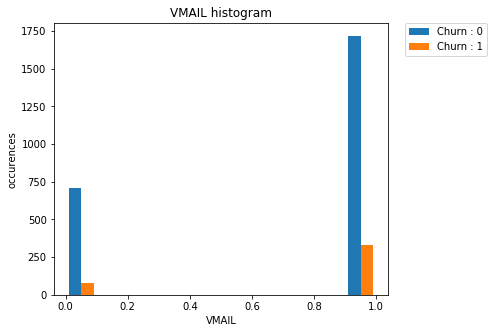

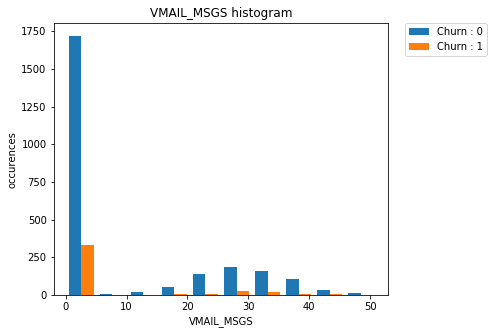

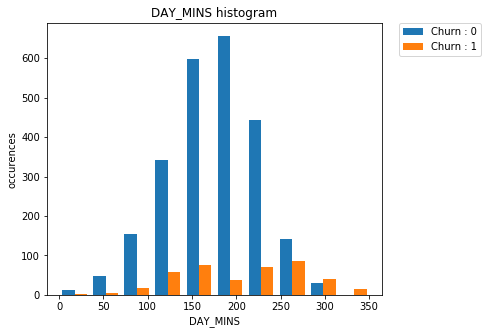

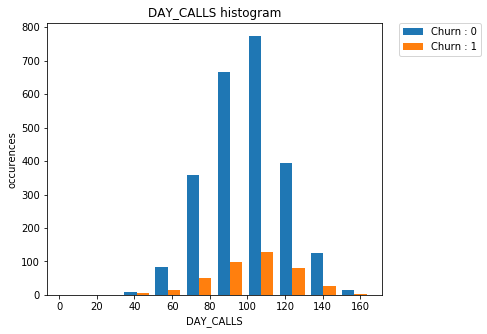

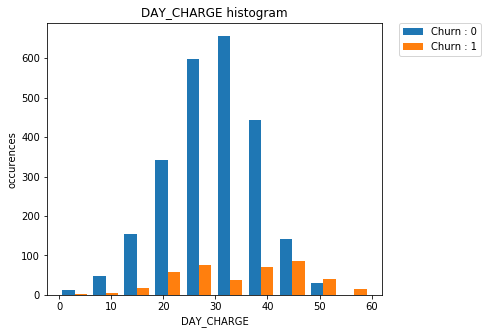

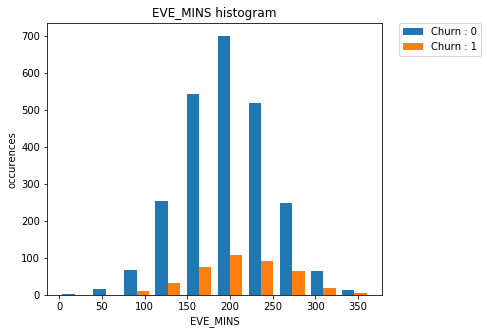

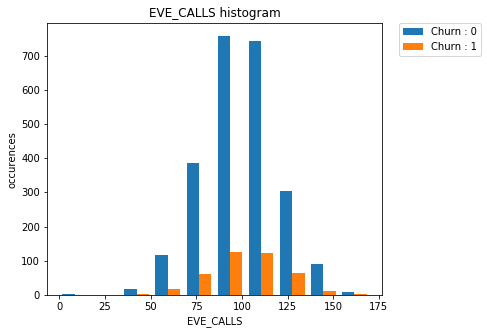

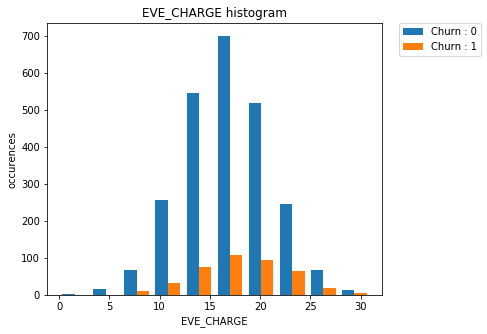

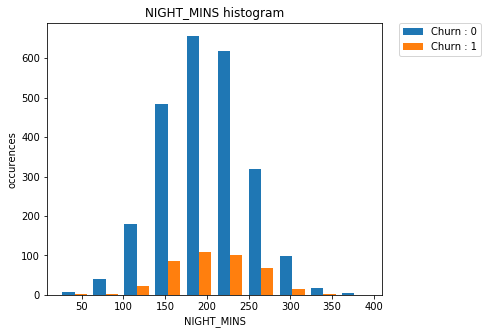

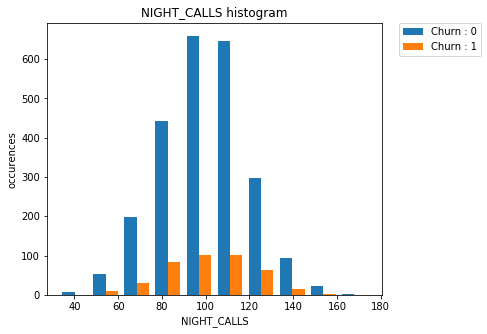

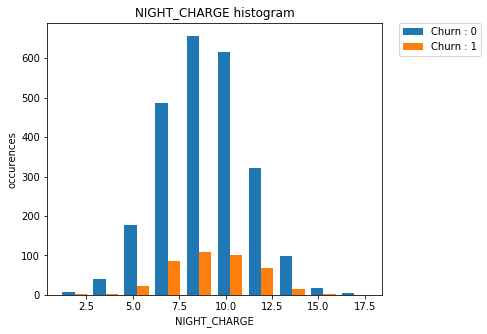

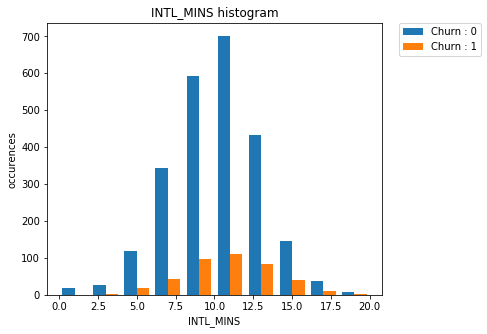

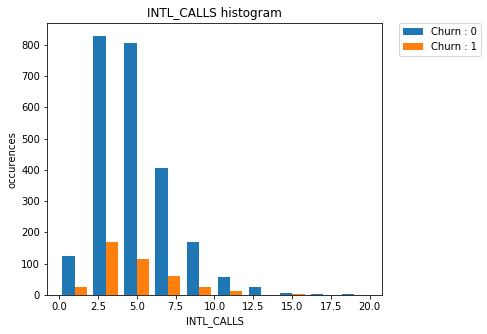

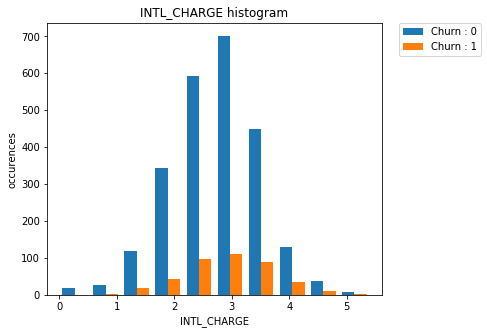

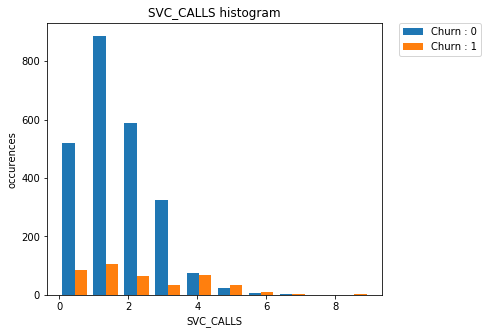

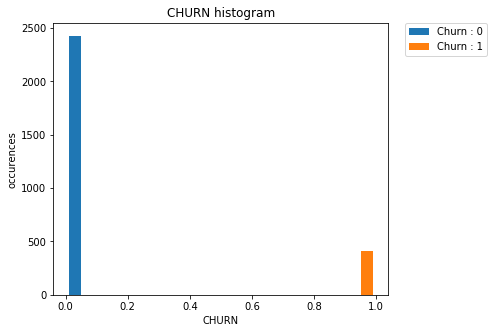

In [14]:
def hist(dataset, nameX, bins=None):
    """
    prerequisites : matplotlib.pyplot as plt; dataset stored under this name
    input : nameX is the name of the feature to be plot on the x-axis
    nameY is the same for the y-axis. They are strings.
    output : plot (x,y) with color code churn
    """
    x0 = dataset[dataset.CHURN == 0][nameX]
    x1 = dataset[dataset.CHURN == 1][nameX]
    
    fig, ax = plt.subplots(figsize=(6,5))
    plt.hist([x0, x1], bins=bins, label = ["Churn : 0", "Churn : 1"])

    plt.xlabel(nameX)
    plt.ylabel("occurences")

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    #plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
    plt.title(nameX + " histogram") 
    plt.show()

cross_val = cross_val_x.copy()
cross_val["CHURN"] = cross_val_y    
col = list(cross_val.columns)

for i in range(1, len(col)):
    hist(cross_val, col[i])

Comments
- most people who have voice mail messages are likely to end their contract, particularly if they receive between 20 and 40 voice messages;
- distribution of number of calls and cumulated time among each category is very similar between classes churn=1 and churn=0. This might make our prediction task hard to perform;
- service calls distributions however differ from class 0 to class 1; 
- area is not a discriminative feature;

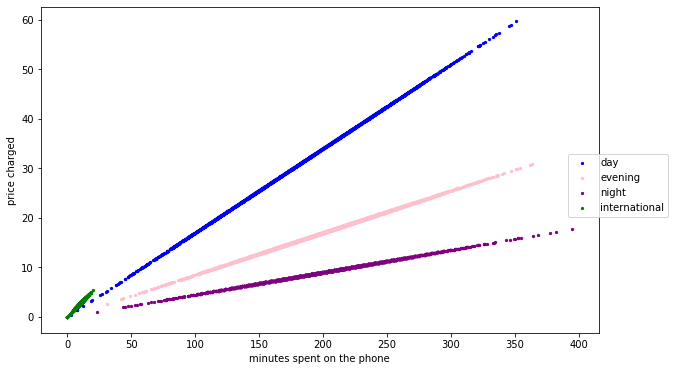

In [15]:
# Price charged per minute - category comparison
def pricing_graph(dataset):
    ax, fig=plt.subplots(figsize=(10,6))

    plt.scatter(dataset['DAY_MINS'], dataset['DAY_CHARGE'], color='blue', s=5, label='day')
    plt.scatter(dataset['EVE_MINS'], dataset['EVE_CHARGE'], color='pink', s=5, label='evening')
    plt.scatter(dataset['NIGHT_MINS'], dataset['NIGHT_CHARGE'], color='purple', s=5, label='night')
    plt.scatter(dataset['INTL_MINS'], dataset['INTL_CHARGE'], color='green', s=5, label='international')


    plt.xlabel('minutes spent on the phone')
    plt.ylabel('price charged')

    ax.legend(loc='right')

    plt.show()
    
pricing_graph(cross_val_x)

Comments 
* Pricing is linear (simple linear function between time and price, no flat rate or minimum charge). 
* So we can leave `_MINS` column outand keep the `_CHARGE`columns only for instance.

In [16]:
def drop_MINS(dataset):
    return dataset.drop(["DAY_MINS", "EVE_MINS", "NIGHT_MINS", "INTL_MINS"], axis=1)

for dataset in [cross_val_x, test_x]:
    dataset = drop_MINS(dataset)

## 3. Train your first models

__Build basic models__

Let's build three basic models on the basis of our data. In this preliminary step, we just use default options to have a glimpse at the potential of logistic regression, random forest and gradient boosted trees. We have defined a seed for the ensemble models, so that results can be reproduced.

In [17]:
lr = LogisticRegression(max_iter=2000, random_state=1, solver = 'lbfgs')
rf = RandomForestClassifier(n_estimators=10, random_state=1)
gbt = GradientBoostingClassifier(n_estimators=10, random_state=1)

__Metrics__

In [18]:
# with 5 folds => 1 fold represents 17% of the orginal dataset

print("Logistic regression")
scores = cross_val_score(lr, cross_val_x, cross_val_y, cv=5, scoring = "recall")               
print("Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(lr, cross_val_x, cross_val_y, cv=5)               
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("")

print("Random Forest")
scores = cross_val_score(rf, cross_val_x, cross_val_y, cv=5, scoring = "recall")            
print("Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(rf, cross_val_x, cross_val_y, cv=5)               
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("")

print("GBT")
scores = cross_val_score(gbt, cross_val_x, cross_val_y, cv=5, scoring = "recall")            
print("Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(gbt, cross_val_x, cross_val_y, cv=5)               
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("")

Logistic regression
Recall: 0.09 (+/- 0.04)
Accuracy: 0.86 (+/- 0.01)

Random Forest
Recall: 0.48 (+/- 0.14)
Accuracy: 0.91 (+/- 0.02)

GBT
Recall: 0.38 (+/- 0.11)
Accuracy: 0.90 (+/- 0.02)



Random forest and GBT are much ahead of logistic regression in terms of recall, which is the metric we aim to maximize. So we will keep these two algorithms for the next step of this notebook, which is hyperparameter tuning.

## 4. Find the best hyperparameters with a grid search

__Choice of hyperparameters__

Which hyperparameters do we want to focus on? First, let's take a look at what hyperparameters are available.

In [19]:
print(rf.get_params())
print(gbt.get_params())

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}
{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_iter_no_change': None, 'presort': 'auto', 'random_state': 1, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


We have already given an arbitrary value to random_state for each estimator.

Regarding random forest, we will focus on n_estimators (number of trees in the forest), max_depth (maximum depth of a tree) and max_features (number of features to consider when looking for the best split). 

As for GBT, we will tweak the learning_rate, n_estimators and max_depth (maximum depth of an individual refression estimator). 

__Grid search__

Now we can define our hyperparameter ranges. We will use an exhaustive grid search to test each combination.

In [20]:
from sklearn.model_selection import GridSearchCV
tunedRF = GridSearchCV(estimator = RandomForestClassifier(random_state=1),
            param_grid = {"n_estimators":[10,40,100,200], "max_depth":[3, 5, 10, 20], 'max_features': ['sqrt', 'log2']},
            scoring = "recall",
            cv = 5).fit(cross_val_x, cross_val_y)

In [21]:
best_rf = tunedRF.best_estimator_
print(tunedRF.best_params_)

{'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}


In [22]:
tunedGB = GridSearchCV(estimator = GradientBoostingClassifier(random_state=1),
            param_grid = {"learning_rate":[0.01, 0.05, 0.1], "n_estimators":[10,40,100,200], "max_depth":[3, 5, 10]},
            scoring = "recall",
            cv = 5).fit(cross_val_x, cross_val_y)

In [34]:
best_gb = tunedGB.best_estimator_
print(tunedGB.best_params_)

{'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 200}


In [24]:
print("RF best recall: %3.f" %tunedRF.best_score_)
print("GB best recall: %3.f" %tunedGB.best_score_)

RF best recall:   1
GB best recall:   1


We have obtained encouraging results on our cross-validation set... but suspect some over-fitting since both models have a perfect recall! Let's assess the performance of our models on the test set.

## 5. Assess your model performance on the test set

__Make predictions and use the confusion matrix__

Let's have a closer look at our model's performances.

In [25]:
def recall(tp,fn):
    return tp/(tp+fn)

def precision(tp, fp):
    return tp/(tp+fp)

# Random Forest
print("Random Forest")
pred_rf = best_rf.predict(test_x)
tn, fp, fn, tp = metrics.confusion_matrix(test_y, pred_rf).ravel()
print("(tn, fp, fn, tp)="+str((tn, fp, fn, tp)))
print("Accuracy:  "+str(best_rf.score(test_x, test_y)))
r = recall(tp,fn)
p = precision(tp, fp)
print("Precision: %.3f" % p)
print("Recall:    %.3f" % r)
print("")

# GBT
print("GBT")
pred_gb = best_gb.predict(test_x)
tn, fp, fn, tp = metrics.confusion_matrix(test_y, pred_gb).ravel()
print("(tn, fp, fn, tp)="+str((tn, fp, fn, tp)))
print("Accuracy:  "+str(best_gb.score(test_x, test_y)))
r = recall(tp,fn)
p = precision(tp, fp)
print("Precision: %.3f" % p)
print("Recall:    %.3f" % r)

Random Forest
(tn, fp, fn, tp)=(418, 7, 30, 45)
Accuracy:  0.926
Precision: 0.865
Recall:    0.600

GBT
(tn, fp, fn, tp)=(415, 10, 26, 49)
Accuracy:  0.928
Precision: 0.831
Recall:    0.653


The model obtained with gradient boosting seems to be the best, since it has a higher recall. Additionally it has a slightly best accuracy and a satisfying precision.

__Plot the ROC curve__

The Receiver-Operator Curve (ROC) gives you a visual display of the sensitivity by specificity for all possible classification cutoffs. In other words, it summarizes the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds.

The true positive rate (TPR) is given by `tp / (tp + tn)` where tp is the number of true positives and tn the number of true negatives. It is also referred to as recall or sensitivity.

The false positive rate (FPR) is given by `fp/(fp+tn)` where fp is the number of false positives and tn the number of true negatives. It is also referred to as inverted specificity.

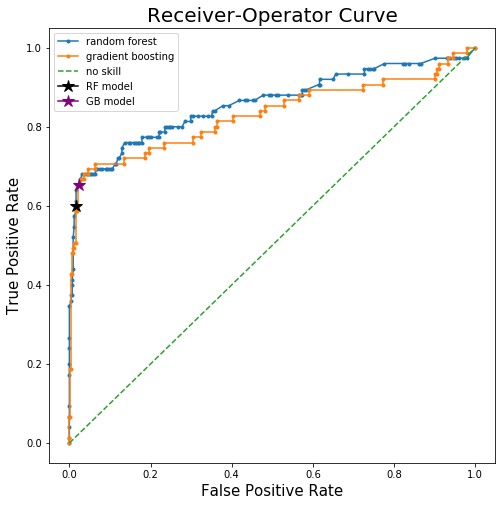

In [26]:
# Extract values
scores_rf=best_rf.predict_proba(test_x) # (p0, p1) format
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(test_y.values, scores_rf[:,1], pos_label=1)

scores_gb=best_gb.predict_proba(test_x) # (p0, p1) format
fpr_gb, tpr_gb, thresholds_gb = metrics.roc_curve(test_y.values, scores_gb[:,1], pos_label=1)

# Define the plot
ax, fig = plt.subplots(figsize=(8,7))
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("Receiver-Operator Curve", fontsize=20)

# ROC curves
plt.plot(fpr_rf, tpr_rf, marker='.')
plt.plot(fpr_gb, tpr_gb, marker='.')

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')

# our models
(tn, fp, fn, tp)=metrics.confusion_matrix(test_y, pred_rf).ravel()
plt.plot([fp/(fp+tn)],[tp/(tp+fn)], color='black', marker='*', markersize=12)
(tn, fp, fn, tp)=metrics.confusion_matrix(test_y, pred_gb).ravel()
plt.plot([fp/(fp+tn)],[tp/(tp+fn)], color='purple', marker='*', markersize=12)

# Legend
plt.legend(["random forest", "gradient boosting", "no skill", "RF model", "GB model"])

Our final model is represented by the stars on the above plot. 

* Area under ROC. 

It should be above 0.5, which is the AUC of a "dummy" model. A model with no skill is represented by the dashed line. It corresponds to a diagonal line from the bottom left of the plot to the top right. 

 The closer the AUC is to 1 (perfect model), the better.

In [27]:
print("Area under ROC curve / RF: "+ str(metrics.roc_auc_score(test_y.values, scores_rf[:,1])))
print("Area under ROC curve / GB: "+ str(metrics.roc_auc_score(test_y.values, scores_gb[:,1])))

Area under ROC curve / RF: 0.8589333333333333
Area under ROC curve / GB: 0.8300549019607845


Here we see that even if our GB model has higher accuracy, precision and recall, its AUC is inferior to the AUC of the RF model. This is due to the particular position of the two on the above curve, right before the inflexion point of each ROC curve.

In fact, ROC curves are more appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets, which is our case here. So let's plot the precision-recall curve. 

__Precision vs Recall__

Precision is the ratio `tp / (tp + fp)` where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier *not to label as positive a sample that is negative*. It is also referred to as the positive predictive value.

Recall is the ratio `tp / (tp + fn)` where tp is the number of true positives as above and fn the number of false negatives. The recall is intuitively the ability of the classifier to *find all the positive samples*. It is also referred to as sensitivity.

The precision recall curve allows us to visualize how both metrics evolve for different thresholds. A perfect classifier could have both precision and recall equal to 1, but in practice a compromise has to be found.

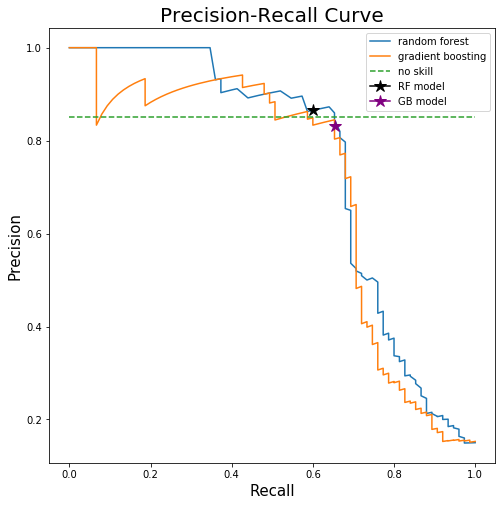

In [28]:
#Extract the values
precision_rf, recall_rf, thresholds_rf = metrics.precision_recall_curve(test_y, scores_rf[:,1])
precision_gb, recall_gb, thresholds_gb = metrics.precision_recall_curve(test_y, scores_gb[:,1])

# Define the plot
ax, fig = plt.subplots(figsize=(8,7))
plt.xlabel("Recall", fontsize=15)
plt.ylabel("Precision", fontsize=15)
plt.title("Precision-Recall Curve", fontsize=20)

# Plot PR curves
plt.plot(recall_rf, precision_rf)
plt.plot(recall_gb, precision_gb)

# Plot no skill curve
plt.plot([0, 1], [0.85, 0.85], linestyle='--')

# Our models
(tn, fp, fn, tp)=metrics.confusion_matrix(test_y, pred_rf).ravel()
plt.plot([tp/(tp+fn)],[tp/(tp+fp)], color='black', marker='*', markersize=12)

(tn, fp, fn, tp)=metrics.confusion_matrix(test_y, pred_gb).ravel()
plt.plot([tp/(tp+fn)],[tp/(tp+fp)], color='purple', marker='*', markersize=12)

# Legend
plt.legend(["random forest", "gradient boosting", "no skill", "RF model", "GB model"])

Note : The no-skill line is defined by the total number of positive cases divide by the total number of positive and negative cases. Points above this line show learning, or "skill". With our final model choice, we are in the skilled zone, it is the purple star above.

* Area under Precision-Recall curve

In [29]:
print("Area under Precision-Recall curve / RF: "+str(metrics.average_precision_score(test_y.values, scores_rf[:,1])))
print("Area under Precision-Recall curve / GB: "+str(metrics.average_precision_score(test_y.values, scores_gb[:,1])))

Area under Precision-Recall curve / RF: 0.7462709460758594
Area under Precision-Recall curve / GB: 0.7059928423040448


Once again, even if its area under precision recalll curve is slightly inferior to the corresponding value for the RF model, our GB model has the best recall. So we shall keep this model for further use.

## 6. Save your model for future use

__Save your model with Joblib__

In [30]:
dump(best_gb, '/tmp/saved_model.joblib') 

['/tmp/saved_model.joblib']

In [31]:
saved_model = load('/tmp/saved_model.joblib') 

In [32]:
# Test it : you should get the same result as previously
test_pred2 = saved_model.predict(test_x)
saved_model.score(test_x, test_y)

0.928

__Close IdaDataBase instances__

To ensure expected behaviors, IdaDataBase instances need to be closed. 
Closing the IdaDataBase is equivalent to closing the connection: once the connection is closed, it is not possible to use the IdaDataBase instance and any IdaDataFrame instances that were opened on this connection anymore.


In [33]:
idadb.close()
#idadb.reconnect()

Connection closed.


## What you've learned

Congratulations!

In this notebook you have seen how to:
* use ibmdbpy to fetch sample data from Db2 
* use sklearn to build train and select classification models 
* deploy a classic ML workflow from data exploration to performance evaluation
* save your model for future use - in a Python UDF function for example.

____ 
## Authors

Eva Feillet - ML intern, IBM Cloud and Cognitive Software, Böblingen, Germany